**Table of Contents**
1. [Crearea Unei Clase Custom Pentru Istoricul Modelului](#creara-unei-clase-custom-pentru-istoricul-modelului)
1. [Processarea Datelor](#procesarea-datelor)
1. [Modelul](#modelul)
    1. [Crearea Modelului](#crearea-modelului)
    1. [Antrenarea Modelului](#antrenarea-modelului)
    1. [Evaluarea Modelului](#evaluarea-modelului)
        1. [Metricile Modelului](#metricile-modelului)
        1. [Optimizarea Pragului de Decizie](#optimizarea-pragului-de-decizie)

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import json
import os

# Creara Unei Clase Custom Pentru Istoricul Modelului

Vom crea o clasa pentru a putea stoca datele din `history` ale modelelor antrenate, deoarece tensorflow nu ofera aceasta functionalitate _out of the box_. De asemena, in aceasta clasa vom crea si functii de vizualizare a datelor metricilor de antrenare si de validare.


In [137]:
class CustomHistory:

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # culori

    def __init__(self, history):
        self.history = history.history
        self.epoch = history.epoch
        self.params = history.params

    def save(self, path):
        """
        Salveaza istoria modelului in fisiere json
        :param path: Calea de baza pentru salvarea fisierelor
        :return: void
        """
        history_to_save = {}
        for key, values in self.history.items():
            history_to_save[key] = [float(value) for value in values]
        with open(f"{path}_history.json", 'w') as file:
            json.dump(history_to_save, file)
        with open(f"{path}_epoch.json", 'w') as file:
            json.dump(self.epoch, file)
        with open(f"{path}_params.json", 'w') as file:
            json.dump(self.params, file)

    @staticmethod
    def load(path):
        """
        Incarca istoria modelului din fisiere json
        :param path: Cala de baza pentru incarcarea fisierelor
        :return: CustomHistory cu istoria modelului
        """
        with open(f"{path}_history.json", 'r') as file:
            history = json.load(file)
        with open(f"{path}_epoch.json", 'r') as file:
            epoch = json.load(file)
        with open(f"{path}_params.json", 'r') as file:
            params = json.load(file)
        # Creating a dummy class to mimic what might be expected by CustomHistory constructor
        dummy_history = type('DummyHistory', (), {
                             'history': history, 'epoch': epoch, 'params': params})()
        return CustomHistory(dummy_history)

    def plot_loss(self,  n: int=0):
        """
        Functie pentru a plota lossul modelului
        :param n: Indicele culorii
        :return: void
        """
        plt.figure(figsize=(15, 10))
        plt.semilogy(self.epoch, self.history['loss'],
                     color=CustomHistory.colors[n], label='Train Loss' )
        plt.semilogy(self.epoch, self.history['val_loss'],
                     color=CustomHistory.colors[n], label='Val Loss' ,
                     linestyle="--")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    def plot_metrics(self, metrics=['loss', 'prc', 'precision', 'recall','accuracy', 'auc'],figsize=(20,15)):
        """
        Functie pentru a plota metricile modelului
        :param metrics: Lista cu numele metricilor
        :param figsize: Dimensiunea figurii din matplotlib
        :return: void
        """
        plt.figure(figsize=figsize)
        for n, metric in enumerate(metrics):
            name = metric.replace("_", " ").capitalize()
            plt.subplot(len(metrics), 2, n+1)
            plt.plot(self.epoch,
                     self.history[metric], color=CustomHistory.colors[0], label='Train')
            plt.plot(self.epoch, self.history['val_'+metric],
                     color=CustomHistory.colors[1], linestyle="--", label='Val')
            plt.xlabel('Epoch')
            plt.ylabel(name)
            if metric == 'loss':
                plt.ylim([0, plt.ylim()[1]])
            elif metric == 'auc':
                plt.ylim([0.8, 1])
            else:
                plt.ylim([0, 1])
            plt.legend()

# Procesarea Datelor

In [62]:
tensor_data_path = os.path.join(os.getcwd(), 'proiect', 'output', 'tensor')

Citire datelor de antrenare, validare si testare.

In [63]:
train_df = pd.read_csv(tensor_data_path + "/train_features_pd.csv")
val_df = pd.read_csv(tensor_data_path + "/val_features_pd.csv")
test_df = pd.read_csv(tensor_data_path + "/test_features_pd.csv")

In [64]:
train_df.dtypes

Customer Location                 object
Transaction ID                    object
Customer ID                       object
Transaction Amount               float64
Transaction Date                  object
Payment Method                    object
Product Category                  object
Quantity                           int64
Customer Age                       int64
Device Used                       object
IP Address                        object
Shipping Address                  object
Billing Address                   object
Is Fraudulent                      int64
Account Age Days                   int64
Transaction Hour                   int64
month                              int64
day_bucket                         int64
day_of_week                        int64
rounded_hour                       int64
fraud_risk_category               object
fraud_risk_category Index        float64
Transaction Amount Log           float64
Transaction Amount Log Vector     object
Transaction Amou

In [65]:
train_df['dense_features'].head(2)

0    [2.0,2.0,1.0,2.0,2.9612166149475554,1.0,4.0]
1    [1.0,2.0,3.0,20.0,4.848701187667443,1.0,1.0]
Name: dense_features, dtype: object

In [66]:
type(train_df['dense_features'][0])

str

Coloana `dense_features` provenita din _Spark_ nu are un tip de date _array_, ci _object(str)_. Pentru a putea folosi aceasta coloana in modelul nostru, vom crea o functie care sa o transforme  intr-un array de float-uri.


In [67]:
import ast

def get_tensor_input(df: pd.DataFrame):
    """
    Tansforma datele din coloana 'dense_features' care este un string in np.array
    :param df: pd.DataFrame
    :return: np.array, np.array
    """
    # ast.literal_eval transforma stringul in lista de floaturi
    return np.array(df['dense_features'].apply(
        ast.literal_eval).apply(lambda x: np.array(x, dtype=np.float32)).to_list()), df["Is Fraudulent"].to_numpy()

In [68]:
train_features, train_labels = get_tensor_input(train_df.copy())
val_features, val_labels = get_tensor_input(val_df.copy())
test_features, test_labels = get_tensor_input(test_df.copy())

In [69]:
type(train_features), type(train_labels)

(numpy.ndarray, numpy.ndarray)

In [70]:
train_features.shape, train_labels.shape

((1178285, 7), (1178285,))

In [71]:
train_labels.sum()

59173

Sa reexaminam coloan de output `Is Fraudulent` pentru a vedea imbalansul de date.


In [72]:
neg, pos = np.bincount(train_labels)
total = pos+neg
print("Postive examples: ", pos)
print("Negative examples: ", neg)
print("Total examples: ", total)
print("Procentul de pozitive: {:.2f}%".format(100*pos/total))

Postive examples:  59173
Negative examples:  1119112
Total examples:  1178285
Procentul de pozitive: 5.02%


Reiteram faptul ca setul de date este foarte imbalansat, doar _5%_ din tranzactii fiind frauduloase. Astfel trebuie sa incercam sa adaptam modelul pentru a face fata acestui dezechilibru:

- Trebuie sa ne asiguram ca in fiecare _batch_ de antrenare exista macar un exemplu de tranzactie frauduloasa. Cum avem _5%_ tranzactii frauduloase, daca _B_ este dimensiunea _batchului_, atunci pentru a avea cel putin o tranzactie frauduloasa in fiecare _batch_ cu o probabilitate de **99%**:

```python
import math

# Probabiliatea de a selecta o tranzactie frauduloasa
probability = 0.05

# Nivelul de incredere dorit pentru a selecta o tranzactie frauduloasa
desired_confidence = 0.01

# Dimensiunea minima a batchului
batch_size = math.ceil(math.log(desired_confidence) / math.log(1 - probability))
print("Batch size minim:", batch_size) # Batch size minim: 90
```

Vom alege insa un _batch size_ de **256** pentru a avea un _batch_ de dimensiune rotunda si a fi siguri.

- Putem folosi _class weights_ pentru a penaliza greselile de clasificare a tranzactiilor frauduloase. Acest lucru se poate face prin calcularea ponderilor claselor astfel incat sa fie invers proportionale cu frecventa lor in setul de date.


In [73]:
import math

# Probabiliatea de a selecta o tranzactie frauduloasa
probability = 0.05

# Nivelul de incredere dorit pentru a selecta o tranzactie frauduloasa
desired_confidence = 0.01

# Dimensiunea minima a batchului
batch_size = math.ceil(math.log(desired_confidence) /
                       math.log(1 - probability))
print("Batch size minim:", batch_size)

Batch size minim: 90


- **De ce sa utilizam un bias initial**: Setarea acestui bias initial ajuta modelul sa inceapa invatarea presupunand o probabilitate reala care reflecta sansa de a intalni un exemplu pozitiv fata de unul negativ.
- **Impact asupra antrenamentului modelului**: Prin utilizarea acestui bias initial, termenul de bias al layerului de iesire este initializat intr-un mod care face ca predictiile initiale ale modelului sa fie mai apropiate de distributia reala a claselor. Fara acest lucru, modelul ar putea prezice excesiv clasa majoritara in fazele incipiente ale antrenamentului, ceea ce ar putea incetini convergenta si afecta performanta generala asupra clasei minoritare, care este de interes principal in cazul nostru.

```python
initial_bias = np.log([pos/neg])
```

- **pos/neg**: Ratia dintre exemplele pozitive si cele negative din setul de date.
- **Utilizarea logaritmului**: Folosirea logaritmului asigura ca bias-ul initial este mai apropiat de 0, ceea ce inseamna ca predictiile initiale ale modelului sunt mai apropiate de distributia reala a claselor.


In [74]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.93982544])

In [75]:
train_df.shape

(1178285, 28)

In [76]:
train_features[0]

array([2.       , 2.       , 1.       , 2.       , 2.9612167, 1.       ,
       4.       ], dtype=float32)

# Modelul


## Crearea Modelului

Vom crea un model cu 3 straturi _Dense_ si un strat de iesire _Sigmoid_ pentru a clasifica tranzactiile. De asemenea, vom folosi _Dropout_ pentru a evita overfitting-ul si _Regularizare_ pentru a reduce complexitatea modelului. De asemenea, vom folosi _class weights_ pentru a penaliza greselile de clasificare a tranzactiilor frauduloase si diferite _callbacks_ pentru a reduce _learning rate-ul_ si a opri antrenamentul daca modelul a atins un plateau. 

In [93]:
METRICS = [
    keras.metrics.BinaryCrossentropy(
        name='cross entropy'),
    keras.metrics.MeanSquaredError(name='Brier score'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),
]


model = keras.Sequential([
    keras.layers.Input(shape=(train_features.shape[-1],)),
    keras.layers.Dense(
        128, activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.001)),
    # pentru a evita overfitting (random deconecteaza 50% din neuroni)
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    # pentru a evita overfitting (random deconecteaza 30% din neuroni)
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu',
                       kernel_regularizer=keras.regularizers.l1(0.001)),
    # pentru a evita overfitting (random deconecteaza 20% din neuroni)
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid',
                       bias_initializer=tf.keras.initializers.Constant(initial_bias)),
    
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(reduction='sum_over_batch_size'),
    metrics=METRICS)

EPOCHS = 250
BATCH_SIZE = 256

# Pentru a nu continua daca am atins un plateau
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=15,
    mode='max',
    restore_best_weights=True)

# Pentru a reduce learning rate-ul daca am atins un plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_prc',
    factor=0.2,
    patience=10,
    min_lr=0.0001)

In [78]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print("Class weights: ", class_weight)

Class weights:  {0: 0.5264374790012081, 1: 9.956272286346813}


In [79]:
# pentru salvarea modelului si a istoriei
history_path = os.path.join(tensor_data_path, 'history')
model_path = os.path.join(tensor_data_path, 'model')

In [80]:
train_labels.reshape(-1, 1).shape

(1178285, 1)

Deoarece tensorflow se asteapta ca etichetele sa fie _2D_, vom face reshape etichetelor.

In [87]:
train_labels= train_labels.reshape(-1, 1)
val_labels = val_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)

In [90]:
train_labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

## Antrenarea Modelului

In [95]:

history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight)


CustomHistory(history).save(history_path)
model.save(model_path+".keras")

Epoch 1/250
4603/4603 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - Brier score: 0.1720 - accuracy: 0.7746 - auc: 0.7940 - cross entropy: 0.5391 - fn: 10392.1064 - fp: 121464.5000 - loss: 0.5723 - prc: 0.2370 - precision: 0.1352 - recall: 0.6483 - tn: 438402.2812 - tp: 19181.0195 - val_Brier score: 0.1994 - val_accuracy: 0.7111 - val_auc: 0.8156 - val_cross entropy: 0.5986 - val_fn: 3663.0000 - val_fp: 81463.0000 - val_loss: 0.6178 - val_prc: 0.3189 - val_precision: 0.1190 - val_recall: 0.7502 - val_tn: 198539.0000 - val_tp: 11002.0000 - learning_rate: 0.0010
Epoch 2/250
4603/4603 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - Brier score: 0.1675 - accuracy: 0.7890 - auc: 0.8009 - cross entropy: 0.5300 - fn: 10374.8506 - fp: 113402.2812 - loss: 0.5625 - prc: 0.2567 - precision: 0.1438 - recall: 0.6479 - tn: 446466.9688 - tp: 19195.8105 - val_Brier score: 0.1554 - val_accuracy: 0.8253 - val_auc: 0.8176 - val_cross entropy: 0.4935 - val_fn: 5263.0000 - val_fp: 46228.0000 - val_loss: 0.5120 - val_prc: 0.3418 

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/home/jovyan/proiect/output/tensor/model.

## Evaluarea Modelului

### Metricile Modelului

Vom defeni o functie pentru a putea vedea metricile modelului antrenat.

In [127]:
def get_metrics(model):
    """
    Functie pentru a obtine metricile modelului
    :param model:  Modelul antrenat din tensorflow
    :return: void
    """
    metrics_names=["loss"]+[m.name for m in METRICS]
    results = model.evaluate(test_features, test_labels,
                                      batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(metrics_names, results):
      print(name, ': ', value)

In [128]:
get_metrics(model)


loss :  0.3709699511528015
cross entropy :  0.36132875084877014
Brier score :  0.0997040793299675
tp :  1160.0
fp :  2207.0
tn :  20205.0
fn :  62.0
accuracy :  0.9039942622184753
precision :  0.34452033042907715
recall :  0.9492635130882263
auc :  0.9784731268882751
prc :  0.7815916538238525


Vom salva modelul si istoria pentru a le putea folosi ulterior.


In [96]:
CustomHistory(history).save(history_path)
model.save(model_path+".keras")

Incarcam modelulului si istoriei din file system.

In [138]:
loaded_history = CustomHistory.load(history_path)
loaded_model = keras.models.load_model(model_path+".keras")

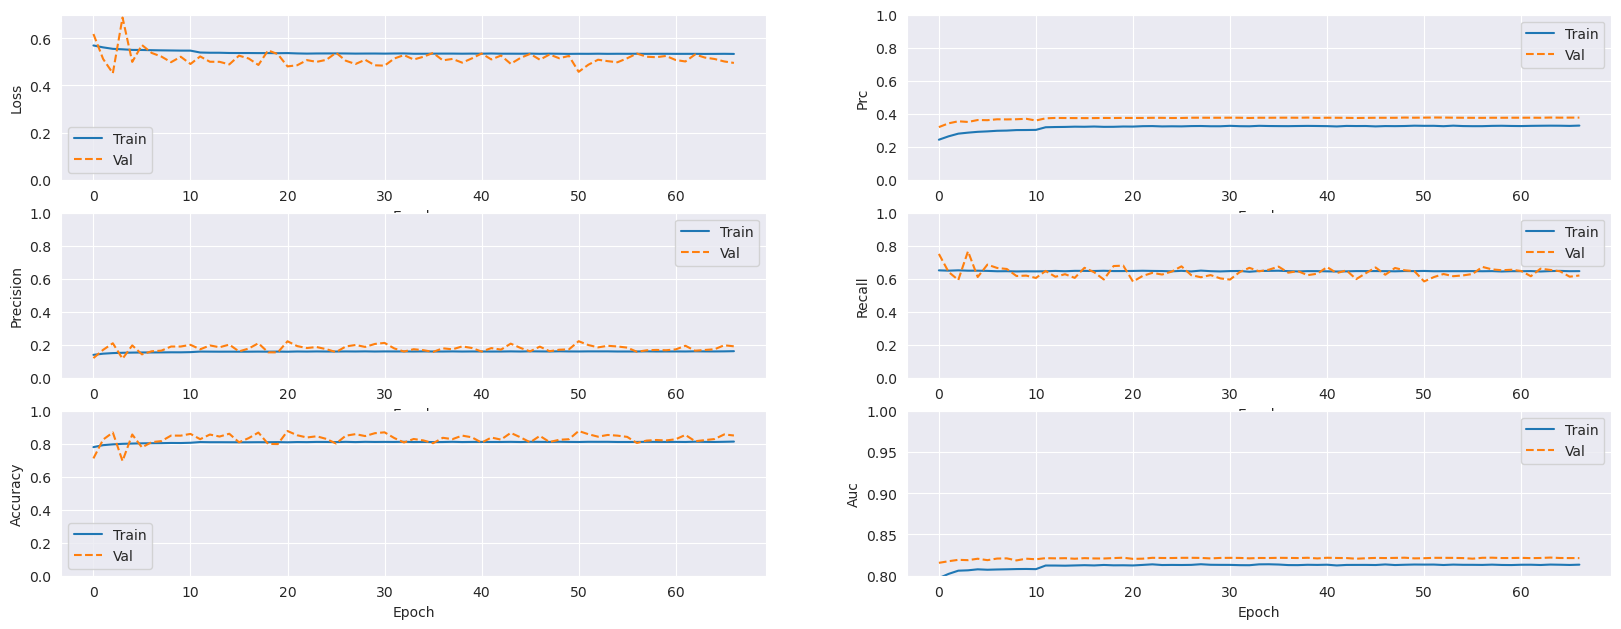

In [139]:
loaded_history.plot_metrics()

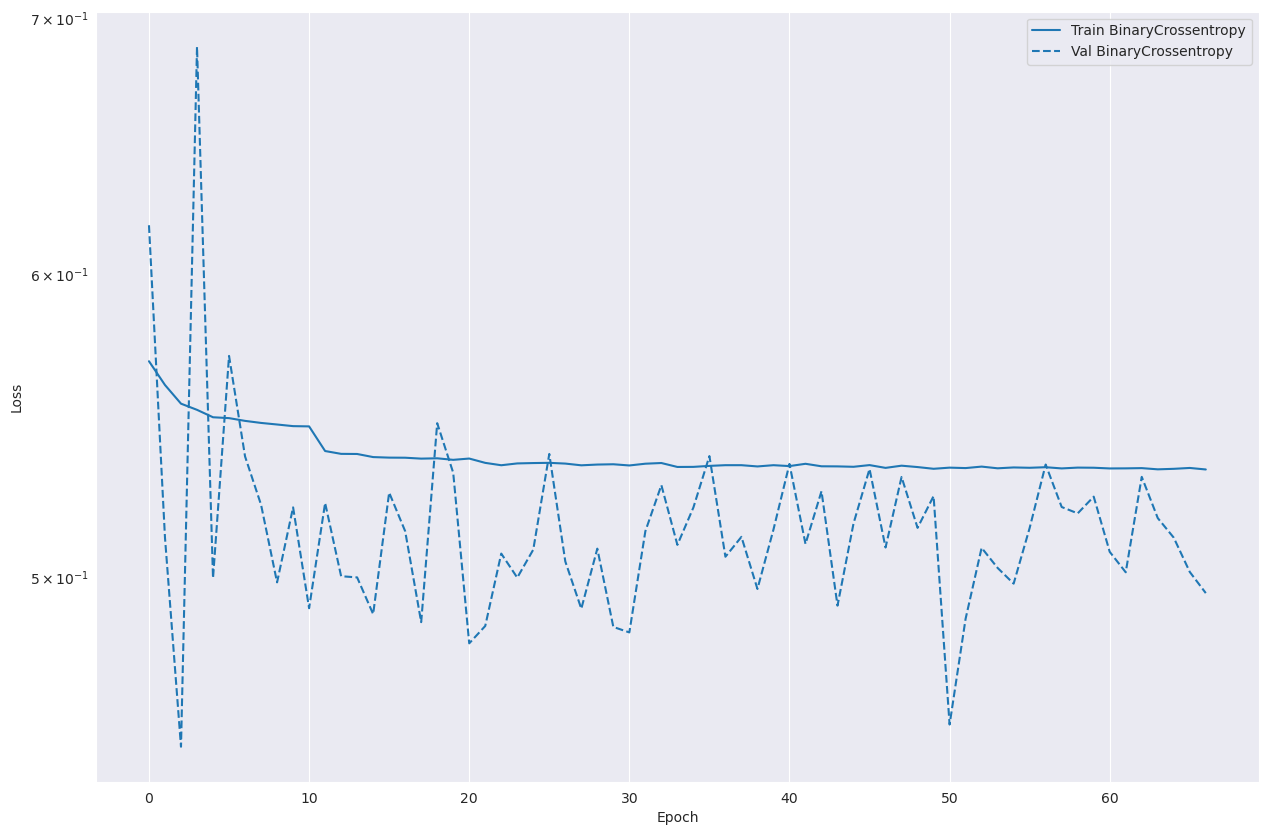

In [99]:
loaded_history.plot_loss()

Observam ca modelul a inceput sa nu se mai imbunatateasca foarte repede, aproapte instantaneu, dupa cateva epoci. Acest lucru se poate datora pe de o parta numarului mic de atribute si pe de alta parte faptului ca in clasa de tranzactii frauduloase sunt foarte putine exemple. De asemenea, putem observa ca modelul nu a facut overfitting, doarece _lossul_ de pe setul de validare si de pe cel de antrenare sunt foarte apropiate.

In [124]:
predictions = loaded_model.predict(test_features)

739/739 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step


In [129]:
get_metrics(loaded_model)


loss :  0.3709699511528015
cross entropy :  0.36132875084877014
Brier score :  0.0997040793299675
tp :  1160.0
fp :  2207.0
tn :  20205.0
fn :  62.0
accuracy :  0.9039942622184753
precision :  0.34452033042907715
recall :  0.9492635130882263
auc :  0.9784731268882751
prc :  0.7815916538238525


### Optimizarea Pragului de Decizie

Predictiile modelului sunt in intervalul [0, 1], iar noi trebuie sa le convertim in clase binare. Pentru a face acest lucru, vom folosi un prag de decizie de 0.5, adica daca predictia este mai mare de 0.5, atunci vom considera ca tranzactia este frauduloasa, altfel va fi considerata ca fiind o tranzactie normala. De asemena, folosind testul de validare vom incerca sa gasim cel mai bun prag de decizie pentru metrica _precision_, _recall_ si _f1 score_.

In [153]:
def find_best_threshold(labels, predictions):
    """
    Functie pentru a gasi cel mai bun prag de decizie
    :param labels: Array cu etichetele reale
    :param predictions: Array cu predictiile modelului
    :return: float
    """
    thresholds = np.arange(0, 1, 0.01)
    
    best_f1 = {'threshold': 0, 'precision': 0, 'recall': 0, 'f1_score': 0}
    best_precision = {'threshold': 0, 'precision': 0, 'recall': 0, 'f1_score': 0}
    best_recall = {'threshold': 0, 'precision': 0, 'recall': 0, 'f1_score': 0}
    
    
    for threshold in thresholds:
        binary_predictions = (predictions > threshold).astype(int)
        
        tp = np.sum((labels == 1) & (binary_predictions == 1))
        tn = np.sum((labels == 0) & (binary_predictions == 0))
        fp = np.sum((labels == 0) & (binary_predictions == 1))
        fn = np.sum((labels == 1) & (binary_predictions == 0))
        
        if tp == 0:
            precision = 0
            recall = 0
        else:
            precision = tp/(tp+fp)
            recall = tp/(tp+fn)
        
        f1_score = 2*(precision*recall)/(precision+recall)
        
        if f1_score > best_f1['f1_score']:
            best_f1['threshold'] = threshold
            best_f1['precision'] = precision
            best_f1['recall'] = recall
            best_f1['f1_score'] = f1_score
        
        if precision > best_precision['precision']:
            best_precision['threshold'] = threshold
            best_precision['precision'] = precision
            best_precision['recall'] = recall
            best_precision['f1_score'] = f1_score
        
        if recall > best_recall['recall']:
            best_recall['threshold'] = threshold
            best_recall['precision'] = precision
            best_recall['recall'] = recall
            best_recall['f1_score'] = f1_score
            
    return {
        'best_f1': best_f1,
        'best_precision': best_precision,
        'best_recall': best_recall
    }

In [154]:
val_predictions = loaded_model.predict(val_features)
best_threshold = find_best_threshold(val_labels, val_predictions)
best_threshold

9209/9209 ━━━━━━━━━━━━━━━━━━━━ 6s 611us/step


{'best_f1': {'threshold': 0.78,
  'precision': 0.35818486961012136,
  'recall': 0.3783839072621889,
  'f1_score': 0.3680074277945419},
 'best_precision': {'threshold': 0.99,
  'precision': 0.9801488833746899,
  'recall': 0.05386975792703717,
  'f1_score': 0.10212655936914228},
 'best_recall': {'threshold': 0.0,
  'precision': 0.04976804324881985,
  'recall': 1.0,
  'f1_score': 0.09481721903973724}}

In [126]:
predictions

array([[0.19524229],
       [0.19527087],
       [0.19524229],
       ...,
       [0.5480879 ],
       [0.19524229],
       [0.19524229]], dtype=float32)

Analog modelelor din _Spark_ vom crea o functie pentru a crea **matricea de confuzie**.

In [143]:
def evaluate_model(labels, predictions, threshold=0.5):
    """
    Functie pentru evaluarea modelului 
    :param labels: Array cu etichetele reale
    :param predictions: Array cu predictiile modelului
    :return: Pandas DataFrame cu matricea de confuzie
    """
    binary_predictions = (predictions > threshold).astype(int)

    tp = np.sum((labels == 1) & (binary_predictions == 1))
    tn = np.sum((labels == 0) & (binary_predictions == 0))
    fp = np.sum((labels == 0) & (binary_predictions == 1))
    fn = np.sum((labels == 1) & (binary_predictions == 0))
    correct = tp+tn
    wrong = fp+fn
    accuracy = (tp+tn)/(tp+tn+fp+fn)

    if tp == 0:
        precision = 0
        recall = 0
    else:
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)

    f1_score = 2*(precision*recall)/(precision+recall)
    print("Correct: ", correct)
    print("Wrong: ", wrong)
    print("True Positives: ", tp)
    print("False Positives: ", fp)
    print("True Negatives: ", tn)
    print("False Negatives: ", fn)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1_score)
  
    return pd.DataFrame({
        "Predicted Fraud": [tp, fp],
        "Predicted OK": [fn, tn]
    }, index=["Actual Fraud", "Actual OK"])

In [145]:
cm_df_05=evaluate_model(test_labels, predictions)

Correct:  21365
Wrong:  2269
True Positives:  1160
False Positives:  2207
True Negatives:  20205
False Negatives:  62
Accuracy:  0.903994245578404
Precision:  0.3445203445203445
Recall:  0.9492635024549918
F1 Score:  0.5055567661799957


In [155]:
cm_df_prec=evaluate_model(test_labels, predictions, threshold=best_threshold['best_precision']['threshold'])

Correct:  22574
Wrong:  1060
True Positives:  162
False Positives:  0
True Negatives:  22412
False Negatives:  1060
Accuracy:  0.9551493610899552
Precision:  1.0
Recall:  0.132569558101473
F1 Score:  0.2341040462427746


In [156]:
cm_df_recall=evaluate_model(test_labels, predictions, threshold=best_threshold['best_recall']['threshold'])

Correct:  1222
Wrong:  22412
True Positives:  1222
False Positives:  22412
True Negatives:  0
False Negatives:  0
Accuracy:  0.0517051705170517
Precision:  0.0517051705170517
Recall:  1.0
F1 Score:  0.09832635983263598


In [157]:
cm_df_f1=evaluate_model(test_labels, predictions, threshold=best_threshold['best_f1']['threshold'])

Correct:  22826
Wrong:  808
True Positives:  855
False Positives:  441
True Negatives:  21971
False Negatives:  367
Accuracy:  0.9658119658119658
Precision:  0.6597222222222222
Recall:  0.6996726677577741
F1 Score:  0.6791104050833995


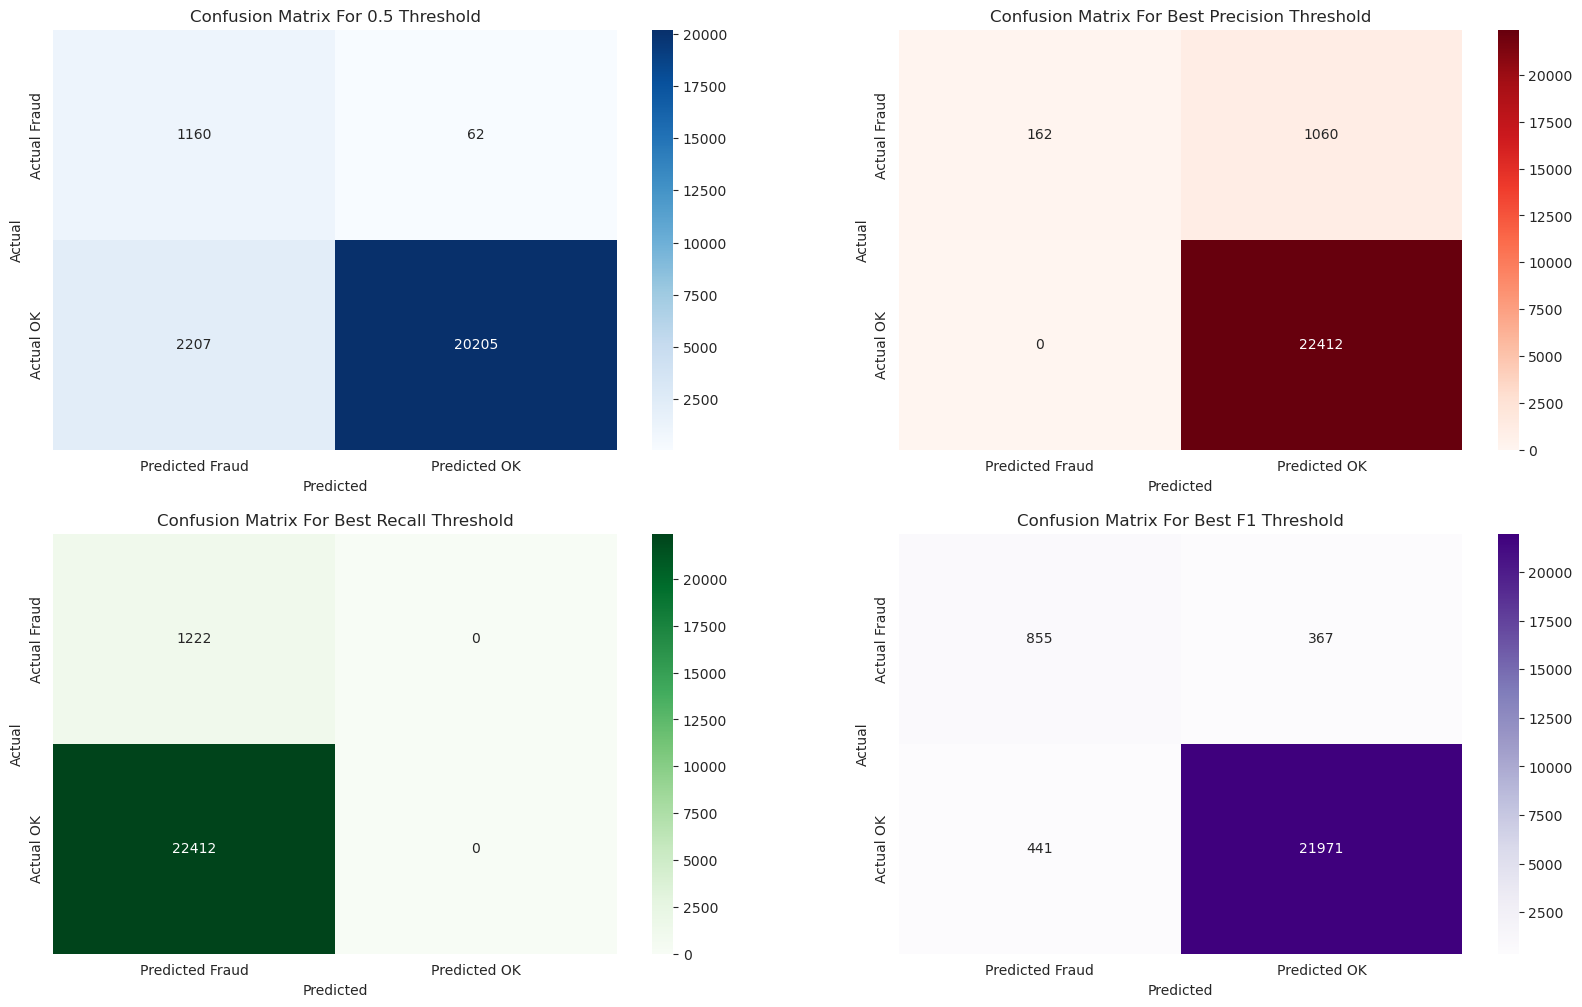

In [161]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
sns.heatmap(cm_df_05, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix For 0.5 Threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.subplot(2, 2, 2)
sns.heatmap(cm_df_prec, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix For Best Precision Threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.subplot(2, 2, 3)
sns.heatmap(cm_df_recall, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix For Best Recall Threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.subplot(2, 2, 4)
sns.heatmap(cm_df_f1, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix For Best F1 Threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Observam ca optimizarea pentru metricile _precision_ si _recall_ duce la rezultate slabe, mai ales pentru _recall_, unde modelul a prezis _0_ tranzactii nefrauduloase corect.

- **Cel mai bun prag pentru _Precision_:**  
  Modelul are o precizie ridicata, ceea ce inseamna ca identifica in mod corect o mare proportie de tranzactii frauduloase. Totusi, acest lucru vine in detrimentul unui numar mai mare de _false negative_. `(precision = tp/(tp+fp))` 

- **Cel mai bun prag pentru _Recall_:**  
  Modelul are un _recall_ ridicat, adica identifica aproape toate tranzactiile frauduloase. Cu toate acestea, modelul prezinta un numar ridicat de _false positive_. `(recall = tp/(tp+fn))`

- **Cel mai bun prag pentru _F1 Score_:**  
  Pragul care maximizeaza F1 score-ul ofera un echilibru intre _precision_ si _recall_. Desi acest prag prezinta mai putine _false negative_ decat pragul implicit (0.5), tot are un numar relativ mare de tranzactii frauduloase ratate. `(f1_score = 2*(precision*recall)/(precision+recall))`

- **Pragul implicit (0.5):**  
  Este pragul utilizat in mod obisnuit pentru clasificarea tranzactiilor. Comparativ cu pragurile optimizate pentru alte metrici, acesta prezinta un echilibru mai bun intre tranzactiile frauduloase si cele nefrauduloase prezise corect, avand un numar rezonabil de _false positive_ si _false negative_.

**Concluzie:**  
Din analiza matricilor de confuzie, observam ca pragul care maximizeaza _F1 Score_ este mai bun decat pragul implicit _0.5_. Totusi, are un numar mai mare de _false negative_, ceea ce din punct de vedere al securitatii este mai grav, intrucat este mai bine sa avem un numar mai mare de _false positive_ decat de _false negative_. Astfel, pragul implicit de 0.5 este cel mai bun prag pentru modelul nostru. 